# Toy Data Set: Two Vars - Balanced Spend - 2x Effect Ratio - Diminishing Returns for FB - Carryover for TV

* Create a toy data set to explore relationships in Robyn
* Data set should include pre-Robyn window period to avoid cold start and take advantage of how Robyn uses data outside the window to estimate carryover marketing effects going into the first window day.
* Balanced spend: we are spending about the same amount on each channel
* Effect ratio: we know that one variable is more effective than the other (ground truth)
* Diminishing return: FB impact on bookings represents diminishing return relationship
* Carryover effects for TV

Diminishing return formulas discussed here: https://gamedev.stackexchange.com/questions/89723/how-can-i-come-up-with-a-simple-diminishing-return-equation.  In effect the following equation is used where SCALE provides overall scale and POW controls how returns are diminished.
* =(POWER(FB_Spend+1,1-POW)-1)/(1-POW)*SCALE

In [1]:
import os
import sys
import math
import pandas as pd
import numpy as np

In [2]:
np.random.seed(43)

bookings_columns = ['bookings_noiseless', 'bookings_noisy', 'bookings_noisy_context']

#
# data set has no lag effect from media at all here
#
for stderr in [600000]:
    print(f'Creating data set with stderr {stderr}')
    df = pd.DataFrame({'date':pd.date_range(start='2015-01-01', end='2021-12-31')})

    # marketing effort
    #
    # random tv marketing from 0 to 10000 each period
    # marketing has a $0 floor on TV spend
    df['tv'] = np.random.randint(0, 10000, size=len(df))
    
    # random fb spend, minimum threshold fb_daily_min each period
    # Marketing has both a non-zero floor and a ceiling on how much to sepend on FB
    fb_daily_min = 2500
    df['fb'] = np.random.randint(0, 5000, size=len(df)) + fb_daily_min
    
    # context variables for testing 
    df['context_0_center'] = np.random.normal( size=len(df))
    df['context_100_center'] = 100 + df.context_0_center
    
    
    fixed_bookings = 10000000
    
    #
    # fb: diminishing
    #
    pow = 0.7    # controls diminishing slope
    neg_pow = 1 - pow
    fb_scale = 25500  # produce result with same order of magnitude as TV
    df['fb_contribution'] = (fb_scale * ((df.fb+1).pow(neg_pow)-1)/neg_pow).astype('int64')
 
    #
    # tv: carryover
    #
    tv_scale = 45
    carry = 0.8  # carryover multiplier
    context_scale = 800000
    
    df['tv_contribution_carry'] = (tv_scale * (df.tv.shift(1) * math.pow(carry,1) + 
                                              df.tv.shift(2) * math.pow(carry,2) +
                                             df.tv.shift(3) * math.pow(carry,3) +
                                             df.tv.shift(4) * math.pow(carry,4) +
                                             df.tv.shift(5) * math.pow(carry,5) +
                                             df.tv.shift(6) * math.pow(carry,6) +
                                             df.tv.shift(7) * math.pow(carry,7) +
                                             df.tv.shift(8) * math.pow(carry,8) +
                                             df.tv.shift(9) * math.pow(carry,9) +
                                             df.tv.shift(10) * math.pow(carry,10)
                                             )).round(0)
    df['tv_contribution'] = (df.tv * tv_scale + df.tv_contribution_carry).round(0)  # NA for early obs so cannot declare int
    df['bookings_noiseless'] = fixed_bookings + df.tv_contribution + df.fb_contribution
    df['bookings_noisy'] = df.bookings_noiseless + np.random.normal(loc=0, scale=stderr, size=len(df)) 
    
    # we use this whether predicting with context_0_center or context_100_center.  Those are two different forms of describing the same context
    df['bookings_noisy_context'] = df.bookings_noisy + df.context_0_center * context_scale
    
    for i in bookings_columns:
        print(f'Checking {i} for negative values')
        assert len(df[df[i]<0]) == 0, f'{i} has negative values which is not permitted'
    
    df.to_csv(os.path.join('data', f'robyn_toy_data_2paidvar_bal_eff2ratio_dimret_carry_{stderr}err.csv'), index=False)


Creating data set with stderr 600000
Checking bookings_noiseless for negative values
Checking bookings_noisy for negative values
Checking bookings_noisy_context for negative values


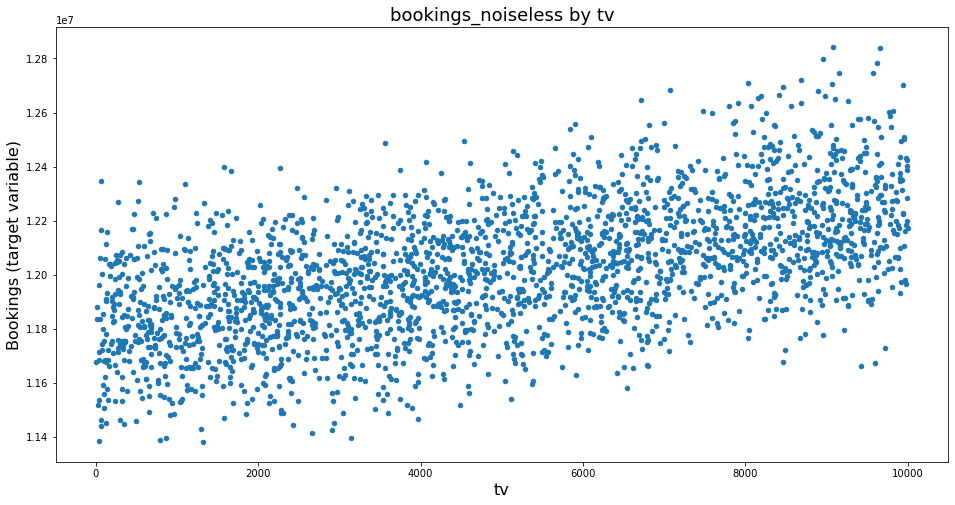

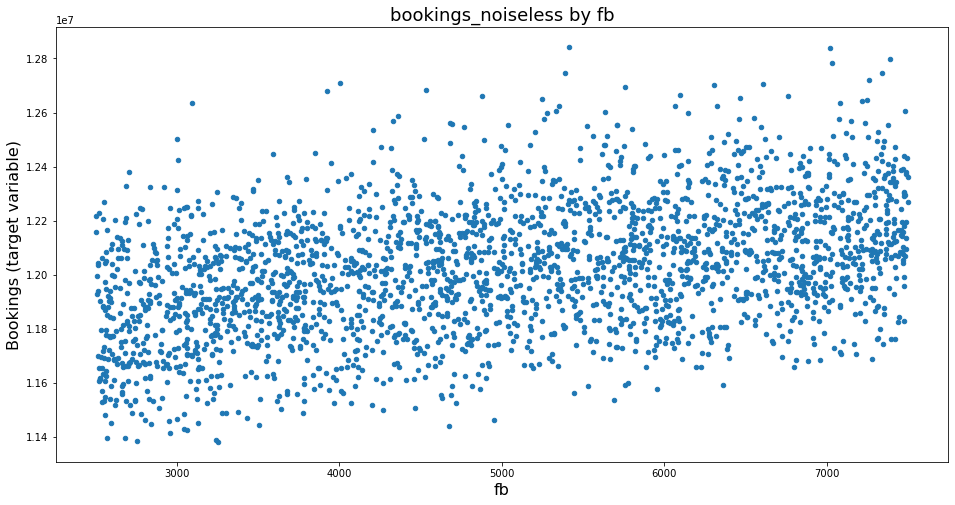

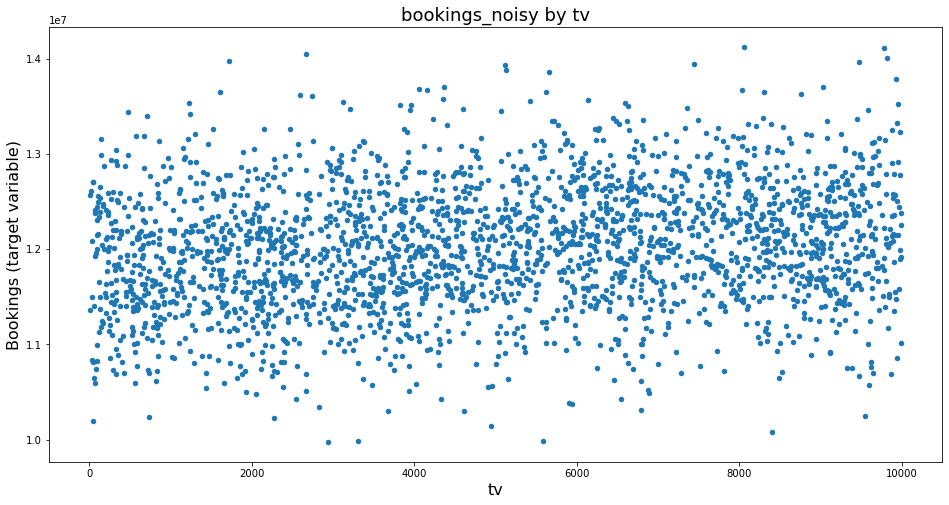

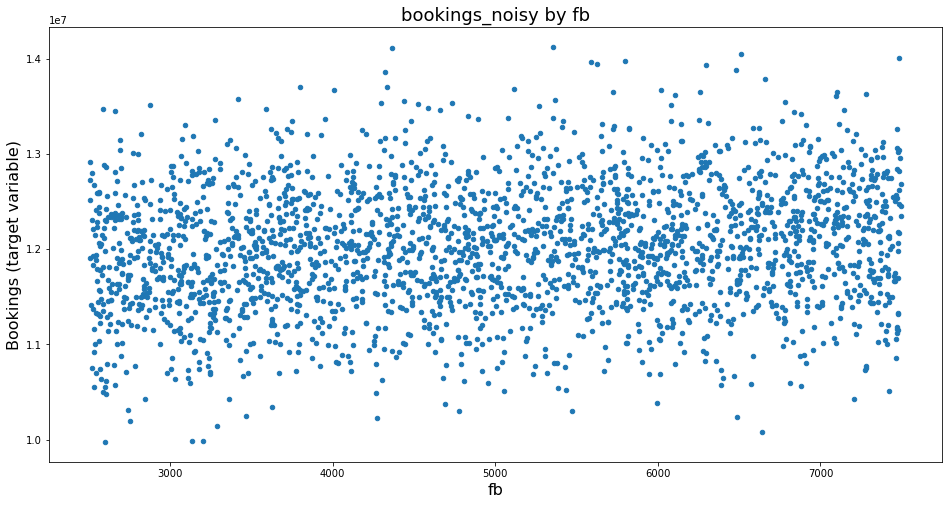

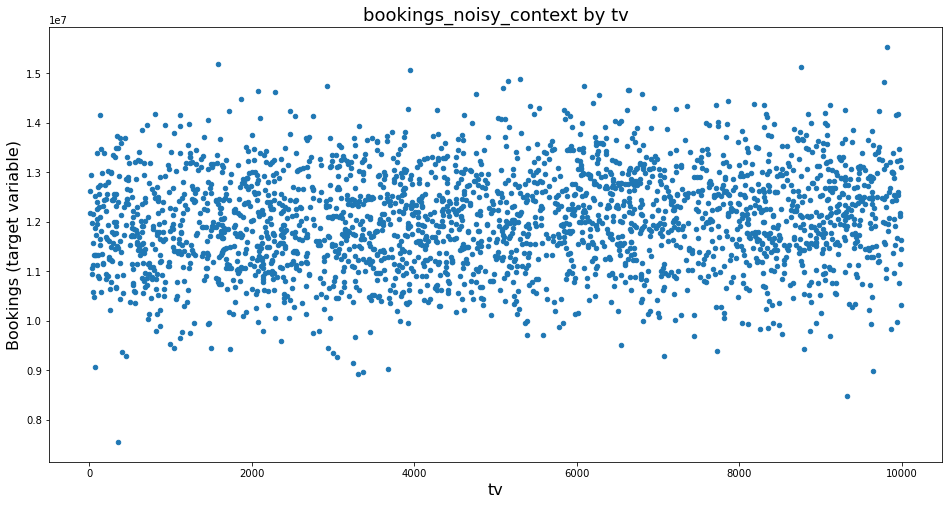

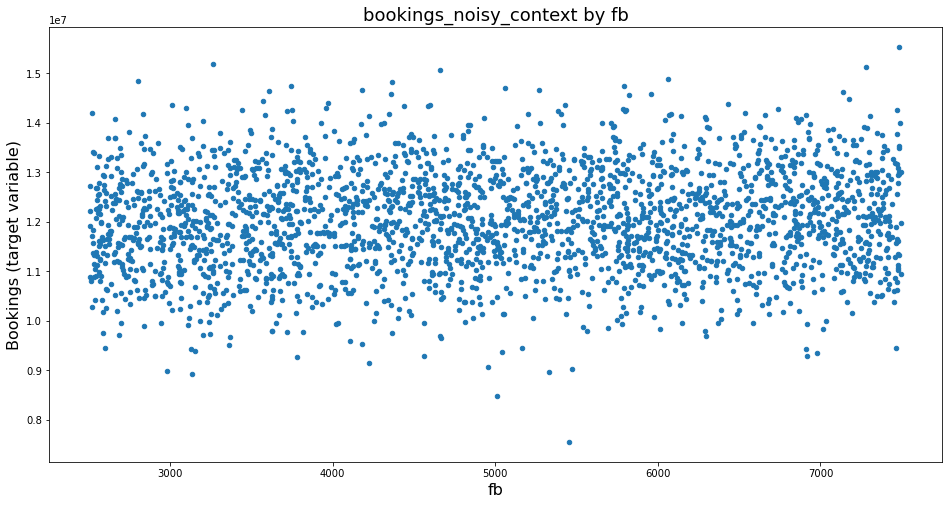

In [3]:
import matplotlib.pyplot as plt

for i in bookings_columns:
    for ivar in ['tv', 'fb']:
        ax = df.plot.scatter(y=i, x=ivar, figsize=(16,8))
        ax.set_title(f'{i} by {ivar}', fontsize=18)
        ax.set_ylabel('Bookings (target variable)', fontsize=16)
        ax.set_xlabel(ivar, fontsize=16)
        plt.show()

In [4]:
for i in bookings_columns:
    print(f'{i}: mean {df[i].mean():.0f} and stddev {df[i].std():.0f}')

bookings_noiseless: mean 12020881 and stddev 236335
bookings_noisy: mean 12020104 and stddev 640985
bookings_noisy_context: mean 12035025 and stddev 1013141


In [5]:
for i in ['fb', 'tv']:
    print(f'{i}: mean {df[i].mean():.0f} and stddev {df[i].std():.0f}')

fb: mean 4996 and stddev 1459
tv: mean 4973 and stddev 2858


## Checking the correct answer in Robyn for 2021 Window

In [6]:
df2021 = df[df['date'] >= pd.to_datetime('2021/01/01', format='%Y/%m/%d')]
len(df2021)

365

In [7]:
df2021.fb_contribution.sum()

362512495

In [8]:
df2021.tv_contribution.sum()

372232548.0

In [9]:
df2021.fb_contribution.sum() / (df2021.tv_contribution.sum()+df2021.fb_contribution.sum())

0.49338542458189816

### Note: The FB spend varies between a min and max, but should still be distinguishable by Robyn

In [10]:
df2021.bookings_noiseless.sum()

4384745043.0

In [11]:
# prove the math that we assume takes place here
df2021.bookings_noiseless.sum() - df2021.fb_contribution.sum() - df2021.tv_contribution.sum() - len(df2021) * fixed_bookings

0.0

## Spend Proportion in this data set

* Note: this data set has spend portion very different from impact portion
* So robyn's minimization of decomp.RSSD will balance against NRMSE

In [12]:
aggs = {
    'fb': 'sum',
    'tv': 'sum'
}
spend_portion = df2021.agg(aggs).reset_index()
spend_portion.rename(columns={'index': 'spend_type', 0: 'spend_amt'}, inplace=True)
spend_portion['percent_of_spend'] = (spend_portion['spend_amt'] / spend_portion['spend_amt'].sum()) * 100
spend_portion

,spend_type,spend_amt,percent_of_spend
0,fb,1797576,49.814896
1,tv,1810935,50.185104


In [13]:
df2021.fb.min()

2514

In [14]:
df2021.fb.max()

7488

In [15]:
df2021.tv.min()

16

In [16]:
df2021.tv.max()

9964

In [17]:
df2021.head(5)

,date,tv,fb,context_0_center,context_100_center,fb_contribution,tv_contribution_carry,tv_contribution,bookings_noiseless,bookings_noisy,bookings_noisy_context
2192,2021-01-01,2078,3016,0.862626,100.862626,855354,899919.0,993429.0,11848783.0,1.215354e+07,1.284364e+07
2193,2021-01-02,9107,4615,1.391517,101.391517,983313,764655.0,1174470.0,12157783.0,1.156520e+07,1.267842e+07
2194,2021-01-03,7741,2564,-0.039573,99.960427,810664,926549.0,1274894.0,12085558.0,1.260296e+07,1.257131e+07
2195,2021-01-04,8972,4040,1.584725,101.584725,941515,1011199.0,1414939.0,12356454.0,1.235924e+07,1.362702e+07
2196,2021-01-05,8360,5526,1.386800,101.386800,1042627,1130018.0,1506218.0,12548845.0,1.211506e+07,1.322450e+07


In [18]:
df2021[df2021.date=='2021-07-01']

,date,tv,fb,context_0_center,context_100_center,fb_contribution,tv_contribution_carry,tv_contribution,bookings_noiseless,bookings_noisy,bookings_noisy_context
2373,2021-07-01,5698,7482,-1.056198,98.943802,1149928,664338.0,920748.0,12070676.0,1.216869e+07,1.132373e+07


In [19]:
df2021.fb_contribution.sum()

362512495

In [20]:
df2021.tv_contribution.sum()

372232548.0

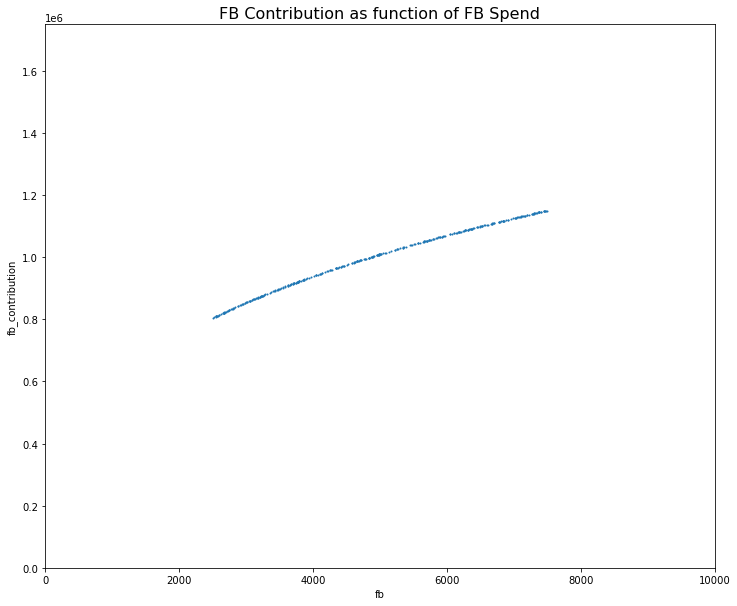

In [21]:
ax=df2021.plot.scatter(y='fb_contribution', x='fb', s=1, figsize=(12, 10))
_=ax.set_title('FB Contribution as function of FB Spend', fontsize=16)
_=ax.set_ylim(0, 1750000)
_=ax.set_xlim(0, 10000)

In [22]:
df2021.head(10)

,date,tv,fb,context_0_center,context_100_center,fb_contribution,tv_contribution_carry,tv_contribution,bookings_noiseless,bookings_noisy,bookings_noisy_context
2192,2021-01-01,2078,3016,0.862626,100.862626,855354,899919.0,993429.0,11848783.0,1.215354e+07,1.284364e+07
2193,2021-01-02,9107,4615,1.391517,101.391517,983313,764655.0,1174470.0,12157783.0,1.156520e+07,1.267842e+07
2194,2021-01-03,7741,2564,-0.039573,99.960427,810664,926549.0,1274894.0,12085558.0,1.260296e+07,1.257131e+07
2195,2021-01-04,8972,4040,1.584725,101.584725,941515,1011199.0,1414939.0,12356454.0,1.235924e+07,1.362702e+07
2196,2021-01-05,8360,5526,1.386800,101.386800,1042627,1130018.0,1506218.0,12548845.0,1.211506e+07,1.322450e+07
2197,2021-01-06,8203,5260,-1.260683,98.739317,1026064,1182118.0,1551253.0,12577317.0,1.227818e+07,1.126963e+07
2198,2021-01-07,7843,4680,0.341954,100.341954,987804,1221547.0,1574482.0,12562286.0,1.294042e+07,1.321399e+07
2199,2021-01-08,9625,7033,0.045846,100.045846,1127214,1221349.0,1654474.0,12781688.0,1.279586e+07,1.283254e+07
2200,2021-01-09,1581,4993,-0.478863,99.521137,1008839,1319072.0,1390217.0,12399056.0,1.234657e+07,1.196348e+07
2201,2021-01-10,1433,5388,0.640286,100.640286,1034106,1094636.0,1159121.0,12193227.0,1.054451e+07,1.105673e+07
